In [35]:
# Base packages
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import os,re, nltk, spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

# Path
folders = './final/'
file_url = folders + 'lematize_corpus_vec.csv'

model_folders = './models/'
dest_model_file_a = model_folders + 'lda_cvec_bi_a.pkl'
dest_model_file_b = model_folders + 'lda_cvec_bi_b.jlb'
dest_model_file_c = model_folders + 'lda_cvec_bi_c_dill.pkl'

gs_model_bk = './gs_models/cvec_bi.model'
dest_df = './dataframe/cvec_bi.csv'
dest_vec = './vectorizer/cvec_bi.vector'

# Init
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
GRAMMAGE = (1, 2)
%matplotlib inline

# Custom
%run -i ./python-code/helper.py
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

In [11]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [6]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",peopl irregular heart beat condit should be cl...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician cathol republ ireland have overwhel...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperatur humid level plummet as...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measur design improv fail hospi...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challeng sleep ...


In [7]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25736
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [8]:
# Quickly clean the contexts
corpus = frame['lemma_text'].values

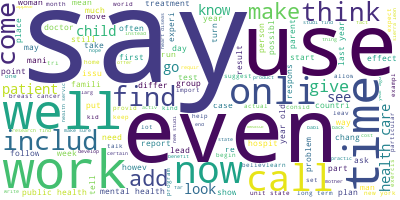

In [6]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [16]:
# Split corpus into TRAIN, TEST, HOLDON
data_train = corpus[:config.TRAIN_SIZE]
TRAIN_SIZE = config.TRAIN_SIZE +1
TEST_SIZE = config.TEST_SIZE + config.TRAIN_SIZE
data_test = corpus[TRAIN_SIZE:TEST_SIZE]
TEST_SIZE = TEST_SIZE + 1
data_holdon = corpus[TEST_SIZE:]

In [9]:
# Create the Document-Word matrix
vectorizer = CountVectorizer(ngram_range = GRAMMAGE,                  
                             analyzer='word',                  # Bi-grams
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=M_STOP_WORDS,            # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(corpus)

In [7]:
# 8. Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

MemoryError: 

In [10]:
# Build LDA Model
lda_model = LDA(n_topics=E_TOPICS,       # Number of topics
              max_iter=10,               # Max learning iterations
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every = -1,       # compute perplexity every n iters, default: Don't
              n_jobs = -1,               # Use all available CPUs
             )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=6, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [9]:
# 10
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -84407632.20001613
Perplexity:  8802.888613546991
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 6,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [11]:
## GridSearchCV
# Define Search Param
search_params = {'n_components': N_COMPONENTS, 'learning_decay': LEARNING_DECAY}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [6, 10, 15, 20, 25, 30, 50], 'learning_decay': ['.3', '.5', '.7', '.9']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': '.9', 'n_components': 15}
Best Log Likelihood Score:  -28757459.604653034
Model Perplexity:  7625.325846220138


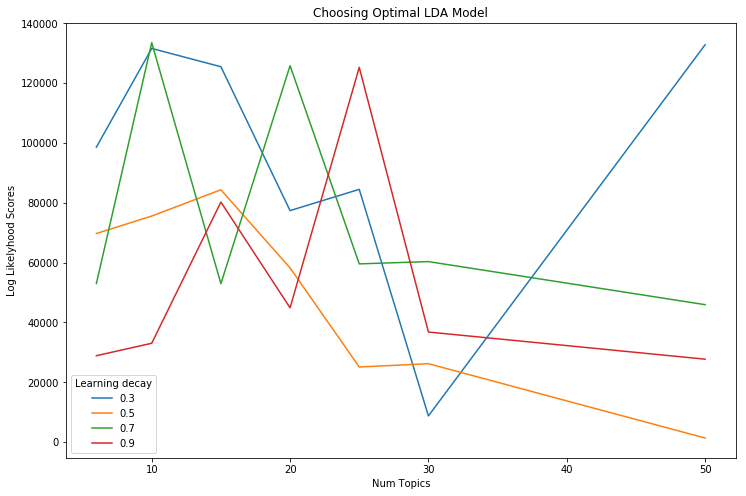

In [13]:
# Get Log Likelyhoods from Grid Search Output
n_topics = search_params['n_components']
learning_decay = LEARNING_DECAY
one_third = len(n_topics)
two_third = one_third*2
three_fourth = one_third*3

gscore = dict(model.cv_results_)
log_likelyhoods_3 = gscore['std_train_score'][0:one_third]
log_likelyhoods_5 = gscore['std_train_score'][one_third:two_third]
log_likelyhoods_7 = gscore['std_train_score'][two_third:three_fourth]
log_likelyhoods_9 = gscore['std_train_score'][three_fourth:]


# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


### 1. Saving Model to disk

In [36]:
# Have: best_lda_model


## ----------------------------------------------------------
## ----------------------------------------------------------
## Pickle
## ----------------------------------------------------------
pickle.dump(best_lda_model,open(dest_model_file_a,'wb'))

## Joblib
## ----------------------------------------------------------
joblib.dump(best_lda_model, dest_model_file_b)

## Dill
## ----------------------------------------------------------
dill.dump(best_lda_model, open(dest_model_file_c,'wb'))

## Vectorizer
## ----------------------------------------------------------
dill.dump(vectorizer, open(dest_vec,'wb'))

## ----------------------------------------------------------
## ----------------------------------------------------------
## Backup GridSearchCV models
## ----------------------------------------------------------
dill.dump(model, open(gs_model_bk,'wb'))

## Best topic
## ----------------------------------------------------------
BEST_TOPICS = model.best_params_['n_components']

In [2]:
best_lda_model = dill.load(open(dest_model_file_c,'rb'))

NameError: name 'dill' is not defined

In [16]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominant_topic
Doc0,0,0,0.37,0,0,0.05,0,0.37,0,0,0.05,0,0.07,0.09,0,2
Doc1,0,0,0,0.09,0,0,0.47,0.09,0,0,0,0.33,0,0,0,6
Doc2,0.13,0,0,0,0,0,0,0,0.16,0,0.44,0.03,0.04,0.19,0,10
Doc3,0,0,0,0.12,0.82,0,0.01,0,0,0,0,0.04,0,0,0,4
Doc4,0,0,0,0,0,0.45,0,0,0,0,0,0,0,0.2,0.35,5
Doc5,0,0,0,0,0.91,0,0,0.02,0,0,0.03,0,0,0.04,0,4
Doc6,0,0,0.33,0,0,0,0,0,0,0.11,0.02,0,0,0,0.54,14
Doc7,0,0,0,0,0,0,0,0.96,0,0,0,0,0,0,0.03,7
Doc8,0,0,0.43,0,0.03,0,0,0.09,0,0,0.16,0.25,0,0.03,0,2
Doc9,0,0,0,0.08,0,0,0.37,0,0.24,0.2,0.11,0,0,0,0,6


In [34]:
df_document_topic.to_csv(dest_df, sep='|')

In [19]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,3610
1,13,3095
2,10,2625
3,5,2463
4,6,2459
5,3,2452
6,4,1622
7,12,1603
8,11,1377
9,9,1300


In [39]:
df_document_topic['dominant_topic'].value_counts(normalize=True)

7     0.140309
13    0.120292
10    0.102025
5     0.095729
6     0.095573
3     0.095301
4     0.063042
12    0.062303
11    0.053519
9     0.050527
8     0.040382
2     0.034708
0     0.019356
14    0.017762
1     0.009173
Name: dominant_topic, dtype: float64

In [20]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Shaynie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      263.840668 -275.303986       1        1  13.058695
13    -534.773987   90.400787       2        1  10.614723
10     266.438019   13.748593       3        1   9.952534
5     -383.925079  338.994293       4        1   9.718424
6      195.289108  288.176666       5        1   9.161221
3     -479.897919 -243.644821       6        1   7.879993
4        9.458172 -407.808136       7        1   7.583766
9     -126.340019  -31.458876       8        1   6.125629
11      25.417507  121.939003       9        1   5.646853
12      61.528381 -142.921814      10        1   4.704764
2     -347.882660  -49.171478      11        1   4.597307
8     -283.272675 -452.031250      12        1   3.850372
0     -183.041733 -241.732300      13        1   2.670736
14     -80.679100  370.469147      14        1   2.634453
1     -228.026367  166.737122      15        1   1.800530, topic_info=       Category          Freq         Term         Total  loglift  logprob
term                                                                      
31731   Default  17542.000000         drug  17542.000000  30.0000  30.0000
40530   Default  16551.000000         food  16551.000000  29.0000  29.0000
103411  Default  32392.000000        studi  32392.000000  28.0000  28.0000
13686   Default  28641.000000         care  28641.000000  27.0000  27.0000
70798   Default  10784.000000          nhs  10784.000000  26.0000  26.0000
46213   Default  53505.000000       health  53505.000000  25.0000  25.0000
113731  Default   9425.000000       vaccin   9425.000000  24.0000  24.0000
76430   Default  39576.000000      patient  39576.000000  23.0000  23.0000
114856  Default  10037.000000        virus  10037.000000  22.0000  22.0000
90710   Default  31373.000000     research  31373.000000  21.0000  21.0000
13109   Default  18204.000000       cancer  18204.000000  20.0000  20.0000
32573   Default  12011.000000          eat  12011.000000  19.0000  19.0000
98525   Default   6003.000000        sleep   6003.000000  18.0000  18.0000
52860   Default  10902.000000       infect  10902.000000  17.0000  17.0000
117158  Default   9288.000000       weight   9288.000000  16.0000  16.0000
38307   Default   8477.000000          fat   8477.000000  15.0000  15.0000
49137   Default  22777.000000       hospit  22777.000000  14.0000  14.0000
53940   Default   6599.000000        insur   6599.000000  13.0000  13.0000
96237   Default  12468.000000       servic  12468.000000  12.0000  12.0000
12818   Default   8183.000000       calori   8183.000000  11.0000  11.0000
16854   Default  21037.000000        child  21037.000000  10.0000  10.0000
47174   Default  10229.000000        heart  10229.000000   9.0000   9.0000
40148   Default   3888.000000          flu   3888.000000   8.0000   8.0000
72386   Default   6352.000000         obes   6352.000000   7.0000   7.0000
29480   Default  19879.000000       diseas  19879.000000   6.0000   6.0000
99007   Default   5498.000000        smoke   5498.000000   5.0000   5.0000
118118  Default  20069.000000        woman  20069.000000   4.0000   4.0000
27831   Default   4597.000000       diabet   4597.000000   3.0000   3.0000
92812   Default  17934.000000         risk  17934.000000   2.0000   2.0000
104332  Default   5857.000000        sugar   5857.000000   1.0000   1.0000
...         ...           ...          ...           ...      ...      ...
26869   Topic15    292.887518       dental    921.524785   2.8708  -6.3479
104332  Topic15    821.602187        sugar   5857.466817   2.0529  -5.3164
26891   Topic15    197.094666      dentist    548.327957   2.9939  -6.7440
10564   Topic15    275.176002  blood sugar   1086.508233   2.6438  -6.4103
109919  Topic15     78.528031    toothpast    113.284392   3.6506  -7.6642
71113   Topic15    285.177306         nice   1296.479373   2.5028  -6.3746
69112   Topic15     89.139950  nation bodi    

In [38]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aafter,aall,aalmost,aan,aand,aani,aanyth,aap,aap committe,...,zucchini lemon,zucchini onion,zucchini red,zucchini round,zucchini salt,zucchini veggi,zucker,zuckerman,zumba,zumba class
Topic0,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic1,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic2,0.066667,0.066667,0.066667,0.066667,5.862224,0.066667,0.066667,2.891272,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic3,0.066667,3.741535,9.642395,7.641940,9.331760,5.728235,0.075081,0.066667,0.078483,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Topic4,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,...,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


In [24]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,flu,vaccin,health,virus,research,human,dog,concuss,peopl,year,make,anim,mental,mental health,strain
Topic 1,diabet,antibiot,sugar,resist,health,tooth,patient,make,help,mosquito,fat,good,need,peopl,year
Topic 2,weight,heart,obes,studi,diet,risk,fat,peopl,blood,high,stroke,vitamin,diseas,low,level
Topic 3,health,care,insur,peopl,year,state,plan,law,cost,pay,new,medic,percent,feder,health care
Topic 4,nhs,care,patient,health,servic,hospit,need,year,staff,trust,make,peopl,govern,provid,support
Topic 5,patient,peopl,doctor,make,time,just,think,know,feel,help,medic,year,good,want,thing
Topic 6,peopl,child,famili,life,year,feel,time,help,make,just,want,know,day,parent,think
Topic 7,cancer,woman,studi,research,child,year,risk,diseas,age,vaccin,peopl,high,babi,rate,test
Topic 8,food,product,eat,make,consum,school,health,peopl,compani,milk,calori,label,nutrit,includ,meat
Topic 9,eat,calori,fat,sugar,make,food,healthi,protein,add,oil,day,serv,gram,low,salt


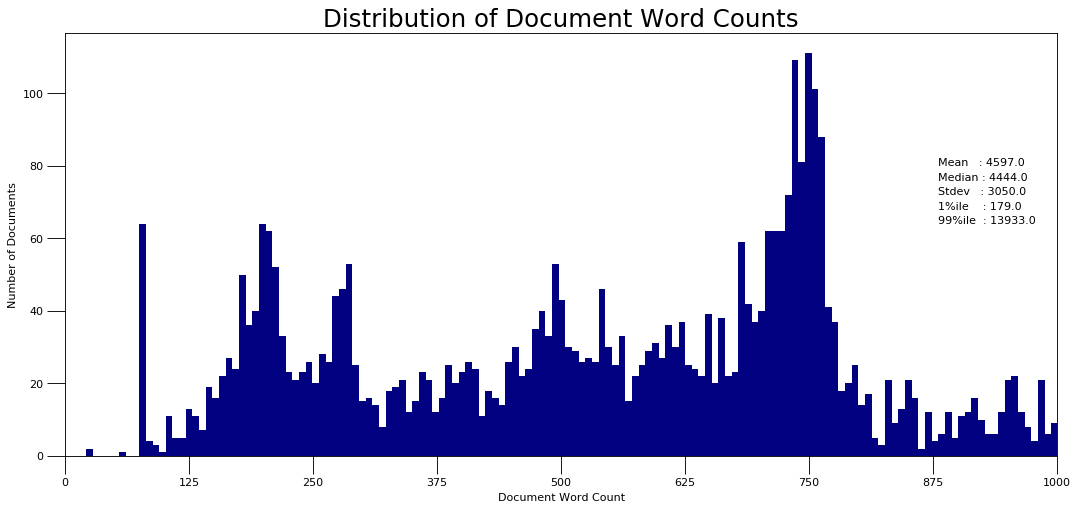

In [21]:
doc_lens = [len(d) for d in frame['list_text'].values]

# Plot
plt.figure(figsize=(16,7), dpi=80)
plt.hist(doc_lens, bins = 10000, color='navy')
plt.text(880, 80, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(880, 76, "Median : " + str(round(np.median(doc_lens))))
plt.text(880, 72, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(880, 68, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(880, 64, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [25]:
unseem_data = '''
Ultra-processed foods - such as chicken nuggets, ice cream and breakfast cereals - have been linked to early death and poor health, scientists say. 
Researchers in France and Spain say the amount of such food being eaten has soared.
Their studies are not definite proof of harm but do come hot on the heels of trials suggesting ultra-processed foods 
.
Experts expressed caution but called for further investigation. 
The term comes from a way of classifying food by how much industrial processing it has been through.
The lowest category is "unprocessed or minimally processed foods", which include: • fruit • vegetables • milk • meat • legumes such as lentils • seeds • grains such as rice • eggs
"Processed foods" have been altered to make them last longer or taste better - generally using salt, oil, sugar or fermentation.
This category includes: • cheese • bacon • home-made bread • tinned fruit and vegetables • smoked fish • beer
Then come "ultra-processed foods", which have been through more substantial industrial processing and often have long ingredient lists on the packet, including added preservatives, sweeteners or colour enhancers. 
If a product contains more than five ingredients, it is probably ultra-processed, says Prof Maira Bes-Rastrollo, of the University of Navarra, citing a maxim.
Examples include: • processed meat such as sausages and hamburgers • breakfast cereals or cereal bars • instant soups • sugary fizzy drinks • chicken nuggets • cake • chocolate • ice cream • mass-produced bread • many "ready to heat" meals such as pies and pizza | meal-replacement shakes 
, by the University of Navarra, in Spain, followed 19,899 people for a decade and assessed their diet every other year. There were 335 deaths during the study.
But for every 10 deaths among those eating the least ultra-processed food, there were 16 deaths among those eating the most (more than four portions a day).
, by the University of Paris, followed 105,159 people for five years and assessed their diet twice a year.
It showed those eating more ultra-processed food had worse heart health. 
Rates of cardiovascular disease were 277 per 100,000 people per year among those eating the most ultra-processed food, compared with 242 per 100,000 among those eating the least. 
The rapid increase of ultra-processed foods over less processed foods, "may drive a substantial burden of cardiovascular diseases in the next decades," said Dr Mathilde Touvier, of the University of Paris.
"[The] evidence is accumulating," said Dr Touvier, noting "increasing numbers of independent studies". Prof Bes-Rastrollo said she was "very certain" ultra-processed foods were bad for health.
Last year, a link was made with 
.
The challenge is being 100% sure. The studies have spotted a pattern between highly processed food and poor health but they cannot prove that one causes the other. 
Those who ate the most ultra-processed food were also more likely to have other unhealthy behaviours, such as smoking, which the researchers tried to account for. 
But there's no guarantee everything relevant was covered, says Kevin McConway, a professor of statistics at The Open University.
"These studies do increase my confidence that there's something real behind these associations - but I'm still far from sure."
The first trial of ultra-processed foods showed they led people to eat more and put on weight. 
Researchers at the US National Institutes of Health monitored every morsel of food that volunteers ate for a month.
And when given ultra-processed food, they ate 500 calories a day more than when they were given unprocessed meals.
Other suggestions include: 
These ideas still need researching.
While the term ultra-processed food may be new, the health advice will be very familiar: adopt a Mediterranean-style diet.
Such a diet includes plenty of minimally or unprocessed foods, such as fruit, vegetables, fish, nuts and seeds, beans, lentils and wholegrains, said Victoria Taylor, senior dietician at the British Heart Foundation.
"This, along with exercising regularly and not smoking, has been shown to be beneficial for lowering risk of heart and circulatory disease."
Measures such as taxation and marketing restrictions on ultra-processed foods, should be considered, said Prof Bes-Rastrollo, given the weight of evidence. 
There are certainly a lot of critics. 
The labelling of food as ultra-processed could be inconsistent, said Dr Gunter Kuhnle, an expert in nutrition and health at the University of Reading
"It is also not obvious why salami is considered to be ultra-processed, yet cheese, which often requires considerably more processing steps and additives, is not.  The classification combines a wide range of foods with very different potential impacts on health, which limits its usefulness as a basis for recommendations."
The studies were published in the British Medical Journal.
'''

In [41]:
# Define function to predict topic for a given text document.

# Predict the topic
# for text in data_test:
#     topic, prob_scores = predict_topic(text = text)
#     print(topic)
topic, prob_scores = predict_topic(unseem_data)
print(topic)
pprint(prob_scores)

[[4.86930284e-03 1.21877316e-04 1.97603989e-01 9.37623114e-03
  1.21877141e-04 9.89802350e-03 1.21877103e-04 6.80622156e-02
  3.38897834e-01 1.64520287e-01 1.11547285e-01 9.44935688e-02
  1.21877134e-04 1.21877299e-04 1.21877126e-04]] 8


[4.181442878733806, 8.827342834584947, 0.0666666725796449, 0.06666673965032849, 5.354646510532624, 5.860979754397235, 0.06666677841514335, 0.06666677069714136, 0.06666671852910329, 0.06666666666666697, 0.5871442504455683, 0.06666667987490661, 0.06666667997774278, 0.06666684843759232, 0.06666667639107628, 0.06666669290619505, 6.736668038715796, 0.06666667292239767, 32.196854099572406, 0.06666666666666671, 0.0666666666666667, 0.06666666666666682, 19.06666666658523, 0.06666666666666687, 0.06666869063219649, 0.06666679729535287, 0.06666666978498201, 0.06666667022348688, 0.06666683490505958, 0.06666766708751391, 0.5028752317052239, 0.06666673242904765, 0.06666674394767742, 0.06666666666666696, 0.06666666843372439, 12.984005795577769, 7.263676413485332, 0.06666669347786633, 0.06666669938253757, 31.741220699944936, 0.0666667888293112, 0.06666670799742688, 13.661338829855643, 0.06666667685177591, 0.0666666718750233, 0.06666666738147463, 19.987202086006906, 0.06666666666666668, 0.06666668479299

array([[4.86930284e-03, 1.21877316e-04, 1.97603989e-01, 9.37623114e-03,
        1.21877141e-04, 9.89802350e-03, 1.21877103e-04, 6.80622156e-02,
        3.38897834e-01, 1.64520287e-01, 1.11547285e-01, 9.44935688e-02,
        1.21877134e-04, 1.21877299e-04, 1.21877126e-04]])


### Fitting with KMeans

Component's weights: 
 [[ 0.05  0.02  0.08  0.3   0.13  0.29  0.28  0.57  0.07  0.06  0.28  0.13
   0.14  0.52  0.04]
 [ 0.02 -0.   -0.08 -0.07 -0.02 -0.14 -0.12 -0.42 -0.02 -0.05 -0.25 -0.05
  -0.04  0.84  0.01]]
Perc of Variance Explained: 
 [0.04 0.14]


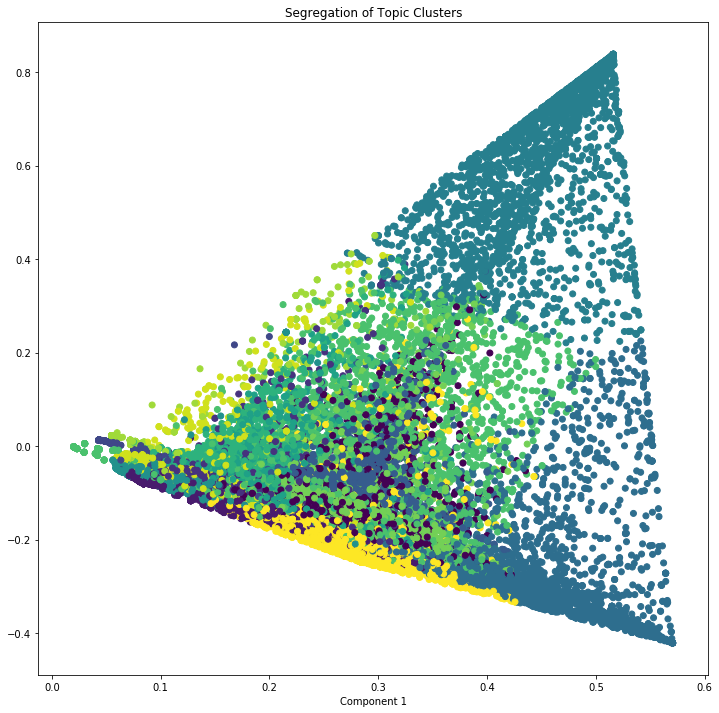

In [27]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=BEST_TOPICS, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plotting clusters
plotting_clusters(x, y, clusters)

In [28]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = corpus, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [29]:
# Get similar documents
doc_ids, docs = similar_documents(text=unseem_data, doc_topic_probs=lda_output, documents = corpus, top_n=1, verbose=True)
print('\n', docs[0][:500])

[[4.86930284e-03 1.21877316e-04 1.97603989e-01 9.37623114e-03
  1.21877141e-04 9.89802350e-03 1.21877103e-04 6.80622156e-02
  3.38897834e-01 1.64520287e-01 1.11547285e-01 9.44935688e-02
  1.21877134e-04 1.21877299e-04 1.21877126e-04]] 8
Topic KeyWords:  ['food', 'product', 'eat', 'make', 'consum', 'school', 'health', 'peopl', 'compani', 'milk', 'calori', 'label', 'nutrit', 'includ', 'meat']
Topic Prob Scores of text:  [[0.  0.  0.2 0.  0.  0.  0.  0.1 0.3 0.2 0.1 0.1 0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.3 0.  0.  0.  0.  0.1 0.2 0.1 0.1 0.1 0.  0.  0. ]]

 grow eat fish famili enjoy fish meal least onc week usual mackerel salmon trout now call steelhead flounder lox pickl herring smoke white fish sabl be occasion treat summer when catch littl sunfish perch local lake mother duti clean pan fri son fish fish too often take sardin sandwich lunch school know would not be trade pb when pull pound carp minnesota river stuff bake delight dinner guest iam thrill too grandson f

### Fitting with DBSCAN

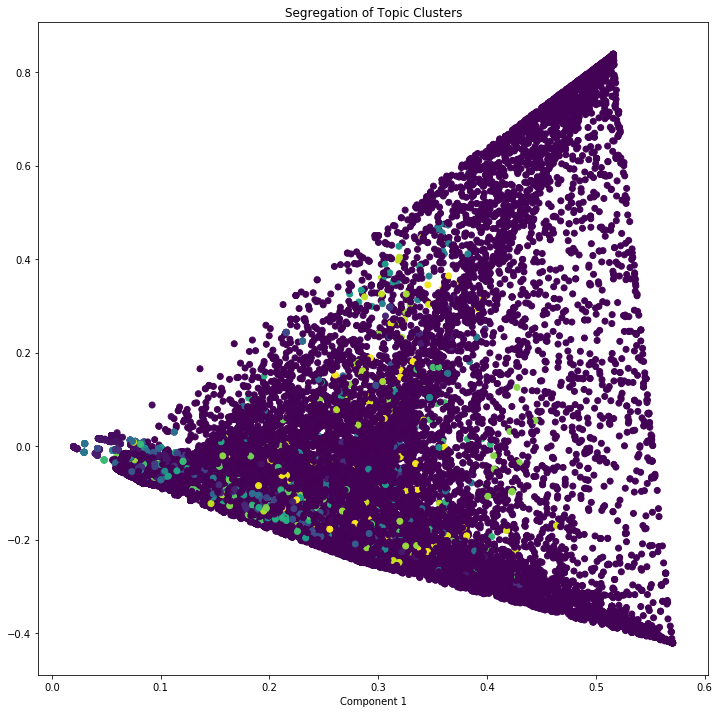

In [30]:
# Construct the DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X = ss.fit_transform(lda_output)

dbscan_clusters = DBSCAN(eps=0.123, min_samples = 4).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plotting clusters
plotting_clusters(x, y, dbscan_clusters)